# Three Body Work-Precision Diagrams

##  Based on
https://github.com/JuliaDiffEq/DiffEqBenchmarks.jl/blob/master/notebook/NonStiffODE/ThreeBody_wpd.ipynb 

In [23]:
using Pkg
using OrdinaryDiffEq,IRKGaussLegendre,Plots,DiffEqDevTools
using DoubleFloats

## Define the ThreeBody Problem

In [24]:
const threebody_μ = parse(Float64,"0.012277471")
const threebody_μ′ = 1 - threebody_μ

const threebody_μD64 = parse(Double64,"0.012277471")
const threebody_μD64′ = 1 - threebody_μD64

f = (du,u,p,t) -> begin
  @inbounds begin
  # 1 = y₁
  # 2 = y₂
  # 3 = y₁'
  # 4 = y₂'
  D₁ = ((u[1]+threebody_μ)^2 + u[2]^2)^(3/2)
  D₂ = ((u[1]-threebody_μ′)^2 + u[2]^2)^(3/2)
  du[1] = u[3]
  du[2] = u[4]
  du[3] = u[1] + 2u[4] - threebody_μ′*(u[1]+threebody_μ)/D₁ - threebody_μ*(u[1]-threebody_μ′)/D₂
  du[4] = u[2] - 2u[3] - threebody_μ′*u[2]/D₁ - threebody_μ*u[2]/D₂
  end
end

f64 = (du,u,p,t) -> begin
  @inbounds begin
  # 1 = y₁
  # 2 = y₂
  # 3 = y₁'
  # 4 = y₂'
  D₁ = ((u[1]+threebody_μD64)^2 + u[2]^2)^(3/2)
  D₂ = ((u[1]-threebody_μD64′)^2 + u[2]^2)^(3/2)
  du[1] = u[3]
  du[2] = u[4]
  du[3] = u[1] + 2u[4] - threebody_μD64′*(u[1]+threebody_μD64)/D₁ - threebody_μD64*(u[1]-threebody_μD64′)/D₂
  du[4] = u[2] - 2u[3] - threebody_μD64′*u[2]/D₁ - threebody_μD64*u[2]/D₂
  end
end

t₀ = 0.0;
T = parse(Float64,"17.0652165601579625588917206249")
T64=parse(Double64,"17.0652165601579625588917206249")
tspan = (t₀,2T)
tspan64=(Double64(0.0),T64)

prob = ODEProblem(f,[0.994,0.0,0.0, parse(Float64,"-2.00158510637908252240537862224")],tspan)
probD64 = ODEProblem(f64,[Double64(0.994),Double64(0.0),Double64(0.0), parse(Double64,"-2.00158510637908252240537862224")],tspan64)

test_sol = TestSolution(T64,[probD64.u0])
#abstols = 1.0 ./ 10.0 .^ (3:13); reltols = 1.0 ./ 10.0 .^ (0:10);

See that it's periodic in the chosen timespan:

In [25]:
sol = solve(prob,Vern9(),abstol=1e-14,reltol=1e-14)
@show sol[1] - sol[end]
@show sol[end] - prob.u0;

sol[1] - sol[end] = [-2.7379654099490836e-11, -8.161904230816544e-11, -1.3315526556367807e-8, -4.261521802106927e-9]
sol[end] - prob.u0 = [2.7379654099490836e-11, 8.161904230816544e-11, 1.3315526556367807e-8, 4.261521802106927e-9]


In [26]:
apr = appxtrue(sol,test_sol)
@show sol[end]
@show apr.u[end]
@show apr.errors

sol[end] = [0.9940000000273796, 8.161904230816544e-11, 1.3315526556367807e-8, -2.0015851021175606]
apr.u[end] = [0.9940000000273796, 8.161904230816544e-11, 1.3315526556367807e-8, -2.0015851021175606]
apr.errors = Dict(:final => 4.4215117994742255e-9)


Dict{Symbol,Double64} with 1 entry:
  :final => 4.4215117994742255e-9

## IRKGL16 Adaptive-Step 

In [27]:
(sol2,iters2,steps2) = @time(solve(prob,IRKGL16(),reltol=1e-12, abstol=1e-12,
                                   adaptive=true,myoutputs=true));

  3.944754 seconds (3.29 M allocations: 146.567 MiB, 1.81% gc time)


In [28]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  11126
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          138
Number of rejected steps:                          18

In [29]:
@show sol2.retcode
@show length(sol2.t)
@show sol2[1] - sol2[end]

sol2.retcode = :Success
length(sol2.t) = 139
sol2[1] - sol2[end] = [-1.9439639444840395e-6, -5.781850545342369e-6, -0.0009429236564166811, -0.00030313649343316484]


4-element Array{Float64,1}:
 -1.9439639444840395e-6 
 -5.781850545342369e-6  
 -0.0009429236564166811 
 -0.00030313649343316484

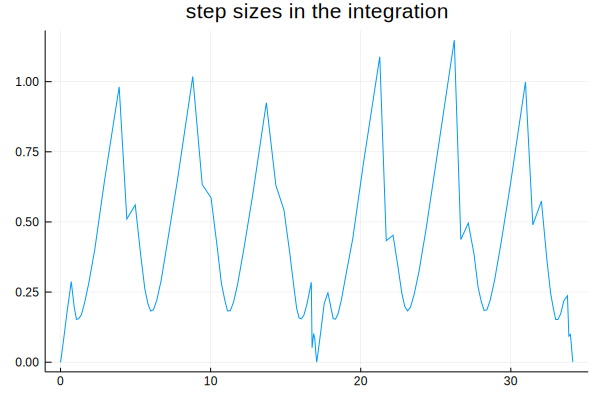

In [30]:
plot(sol2.t,steps2, title="step sizes in the integration", legend=false)

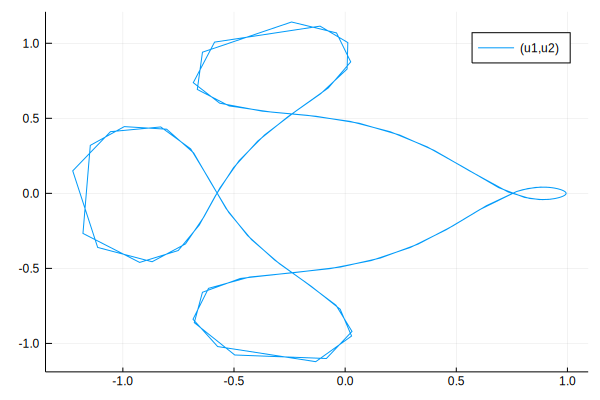

In [31]:
plot(sol2,vars=(1,2))

In [32]:
apr = appxtrue(sol2,test_sol)
@show sol2[end]
@show apr.u[end]
@show apr.errors

sol2[end] = [0.9940019439639445, 5.781850545342369e-6, 0.0009429236564166811, -2.001281969885649]
apr.u[end] = [0.9940019439639445, 5.781850545342369e-6, 0.0009429236564166811, -2.001281969885649]
apr.errors = Dict(:final => 0.00031344649108495384)


Dict{Symbol,Double64} with 1 entry:
  :final => 0.00031344649108495384

## Higher Order Algorithms

In [33]:
abstols = 1.0 ./ 10.0 .^ (8:16)
reltols = 1.0 ./ 10.0 .^ (8:16)
@show abstols
@show reltols;

abstols = [1.0e-8, 1.0e-9, 1.0e-10, 1.0e-11, 1.0e-12, 1.0e-13, 1.0e-14, 1.0e-15, 1.0e-16]
reltols = [1.0e-8, 1.0e-9, 1.0e-10, 1.0e-11, 1.0e-12, 1.0e-13, 1.0e-14, 1.0e-15, 1.0e-16]


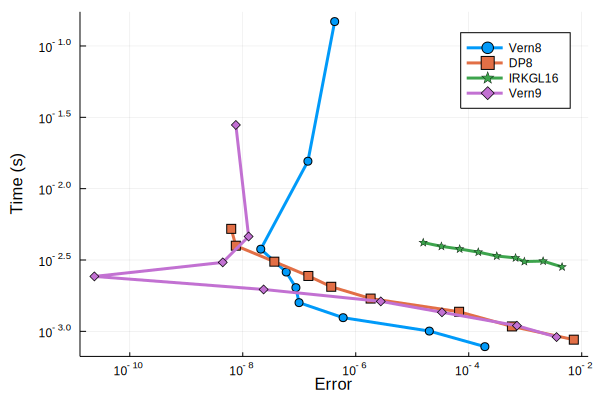

In [34]:
setups = [Dict(:alg=>Vern8())
          Dict(:alg=>DP8())
          Dict(:alg=>IRKGL16())   
          Dict(:alg=>Vern9())];
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100)
plot(wp)